# Spike NLP BERT Model Runner

In this notebook I will cover how to run the original model runner in depth. This is the order in what will be covered:
1) [Creation of the database from the RBD fasta files.](#creating-the-spike-protein-database)
2) [Running of the two BERT models.](#bert)

For more in depth detail about the development process of this model, I recommend looking at the `development_notes.ipynb` notebook. We have two different versions of the BERT model runner, and I will cover how to use both:
- [BERT](#bert)
    - [Non-Parallelized BERT](#non-parallelized-bert) - `runner.py`
    - [DistributedDataParallel (DDP) BERT](#distributeddataparallel-bert) - `gpu_ddp_runner.py`

For our model training, we utilized 1 to 4 NVIDIA a100 80 GB GPUs. It is recommended to utilized GPU over CPU due to improved performance (especally in terms of speed).

In [27]:
import sqlite3
from Bio import SeqIO
import os
import csv

import copy
import torch
import torch.nn as nn
from pnlp.embedding.nlp_embedding import NLPEmbedding
from pnlp.model.transformer import TransformerBlock

import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import datetime
import random
from datetime import date
from typing import Union
import logging
import numpy as np
import tqdm
from torch.utils.data import DataLoader
from collections import defaultdict, OrderedDict
from pnlp.db.dataset import SeqDataset, initialize_db
from pnlp.embedding.tokenizer import ProteinTokenizer, token_to_index, index_to_token
from pnlp.embedding.nlp_embedding import NLPEmbedding

import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.elastic.multiprocessing.errors import record

---
## Creating the Spike Protein Database
This section covers the creation of the database `SARS_CoV_2_spike_noX_RBD.db`, adapted from the script `make_db.py`. First, lets import the necessary code from the script. Here is an overview of what each function does:

- `extract_fasta`: For use in `make_fasta_db`, extracts the fasta entries from fasta file.
- `make_fasta_db`: Creates the db from the fasta entries.
- `test_db_contents`: Tests that the db was created properly by looking at the first 5 rows of the table.

In [8]:
def extract_fasta(train_file:str, test_file:str):
    training_seqs = list(SeqIO.parse(open(train_file),'fasta'))
    testing_seqs = list(SeqIO.parse(open(test_file), 'fasta'))
    return training_seqs , testing_seqs

def make_fasta_db(db_name:str, train_file:str, test_file:str):
    training_seqs, testing_seqs = extract_fasta(train_file, test_file)
    conn = sqlite3.connect(db_name)
    db_cursor = conn.cursor()

    # Create train, test sequences table
    db_cursor.execute('''CREATE TABLE train (id INTEGER PRIMARY KEY AUTOINCREMENT, header TEXT, sequence TEXT)''')
    db_cursor.execute('''CREATE TABLE test (id INTEGER PRIMARY KEY AUTOINCREMENT, header TEXT, sequence TEXT)''')

    for mode, table_name in zip([training_seqs, testing_seqs], ["train", "test"]):
        for fasta in mode:
            header, seq = fasta.id, str(fasta.seq)
            db_cursor.execute(f"INSERT INTO {table_name} (header, sequence) VALUES (?,?)", (header, seq))
        conn.commit()

    conn.close()
    print(f'Database {db_name} initialized.')

def test_db_contents(db_name:str):
    conn = sqlite3.connect(db_name)
    db_cursor = conn.cursor()

    # Check if the tables 'train' and 'test' exist and fetch their content
    for table_name in ['train', 'test']:
        db_cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
        if db_cursor.fetchone() is not None:
            print(f"The table '{table_name}' exists.")
            print(f"First 5 rows of the '{table_name}' table:")
            db_cursor.execute(f"SELECT * FROM {table_name} LIMIT 5")
            rows = db_cursor.fetchall()
            for row in rows:
                print(row)
            print("")
        else:
            print(f"The table '{table_name}' does not exist.")
            return False

    conn.close()
    return True

Alright, let's create and test our db now! We'll move on to using it in our model runner afterwards.

In [9]:
# RBD db creation
data_dir = '../data'
train_fasta = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD_train.fasta')
test_fasta = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD_test.fasta')
db_name = os.path.join(data_dir, 'SARS_CoV_2_spike_noX_RBD.db')
make_fasta_db(db_name, train_fasta, test_fasta)

# Test contents
if test_db_contents(db_name):
    print(f"The database '{db_name}' is initialized correctly.")
else:
    print(f"There is an issue with the database '{db_name}'.")

Database ../data/SARS_CoV_2_spike_noX_RBD.db initialized.
The table 'train' exists.
First 5 rows of the 'train' table:
(1, 'EPI_ISL_14656994', 'RVQPTESIVRFPNITNLCPFDEVFNATTFASVYAWNRKRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGVNCYFPLQSYGFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF')
(2, 'EPI_ISL_4362398', 'RVQPTESIVRFPNITNLCPFGEVFNATKFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF')
(3, 'EPI_ISL_12167686', 'RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYGFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF')
(4, 'EPI_ISL_3759201', 'RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNY

--- 
## BERT
Below is a closer look at the base BERT model (`bert.py`) that we use. This is then fed into a ProteinLM model (`language.py`) as our final BERT Protein ML model that we train.

In [13]:
class BERT(nn.Module):
    """ BERT model. """

    def __init__(self,
                 embedding_dim: int,
                 dropout: float,
                 max_len: int,
                 mask_prob: float,
                 # hidden: int,
                 n_transformer_layers: int,
                 attn_heads: int):
        """
        embedding_dim: dimensions of embedding
        hidden: BERT model size (used as input size and hidden size)
        n_layers: number of Transformer layers
        attn_heads: attenion heads
        dropout: dropout ratio
        """

        super().__init__()
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.max_len = max_len
        self.mask_prob = mask_prob

        self.hidden  = embedding_dim
        self.n_transformer_layers = n_transformer_layers
        self.attn_heads = attn_heads
        self.feed_forward_hidden = self.hidden * 4         # 4 * hidden_size for FFN

        self.embedding = NLPEmbedding(self.embedding_dim, self.max_len, self.dropout)

        def clones(module, n):
            """Produce N identical layers"""
            return nn.ModuleList([copy.deepcopy(module) for _ in range(n)])

        self.transformer_blocks = clones(TransformerBlock(self.hidden, self.attn_heads, self.feed_forward_hidden, self.dropout), self.n_transformer_layers)

    def forward(self, x: torch.Tensor):
        embedded_seqs, mask_tensor = self.embedding(x)   # tokenized batch sequences

        for transformer in self.transformer_blocks:
            x = transformer.forward(embedded_seqs, mask_tensor)
        return x
    
class ProteinMaskedLanguageModel(nn.Module):
    """ Masked language model for protein sequences. """

    def __init__(self, hidden: int, vocab_size: int):
        """
        hidden: input size of the hidden linear layers
        vocab_size: vocabulary size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)

    def forward(self, x):
        return self.linear(x)

class ProteinLM(nn.Module):
    """ BERT protein language model. """

    def __init__(self, bert: BERT, vocab_size: int):
        super().__init__()
        self.bert = bert
        self.mlm = ProteinMaskedLanguageModel(self.bert.hidden, vocab_size)

    def forward(self, x):
        x = self.bert(x)
        return self.mlm(x)

Now, lets introduce some functions and classes that we will use later. First, let's introduce `ScheduledOptim` for learning rate scheduling (it's in both `runner.py` and `gpu_runner.py`).

In [21]:
class ScheduledOptim():
    """A simple wrapper class for learning rate scheduling from BERT-pytorch.

    Author: codertimo
    https://github.com/codertimo/BERT-pytorch/blob/master/bert_pytorch/trainer/optim_schedule.py
    """

    def __init__(self, optimizer, d_model: int, n_warmup_steps):
        self._optimizer=optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        """Learning rate scheduling per step"""
        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

Now, let's introduce the plotting function from `runner_util.py`. This will plot our recorded train and test loss and accuracy. This is also how we generated Supplementary Figure S1BCDE, as well as Supplementary Figure S2BC.

In [17]:
def plot_run(csv_name: str, save: bool = True):
    '''
    Generate a single figure with subplots for training loss and training accuracy
    from the model run csv file.

    For runner.py and gpu_ddp_runner.py
    '''
    df = pd.read_csv(csv_name)
    df.columns = df.columns.str.strip()

    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")

    # Converting mm to inches for figsize
    width_in = 88/25.4 # mm to inches
    ratio = 16/9
    height_in = width_in/ratio 
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(width_in, 2*height_in))
    plt.rcParams['font.family'] = 'sans-serif'

    # Set the font size
    font_size = 8

    # Plot Training Loss
    train_loss_line = ax1.plot(df['epoch'], df['train_loss'], color='red', linewidth=0.5, label='Train Loss')
    test_loss_line = ax1.plot(df['epoch'], df['test_loss'], color='orange', linewidth=0.5, label='Test Loss')
    ax1.set_ylabel('Loss', fontsize=font_size)
    ax1.legend(loc='upper right', fontsize=font_size)
    ax1.tick_params(axis='both', which='major', labelsize=font_size)
    ax1.yaxis.get_offset_text().set_fontsize(font_size) 
    ax1.set_ylim(-0.5e6, 8e6) 

    # Plot Training Accuracy
    train_accuracy_line = ax2.plot(df['epoch'], df['train_accuracy']*100, color='blue', linewidth=0.5, label='Train Accuracy')
    test_accuracy_line = ax2.plot(df['epoch'], df['test_accuracy']*100, color='green', linewidth=0.5, label='Test Accuracy')
    ax2.set_xlabel('Epoch', fontsize=font_size)
    ax2.set_ylabel('Accuracy', fontsize=font_size)
    ax2.set_ylim(0, 100) 
    ax2.legend(loc='lower right', fontsize=font_size)
    ax2.tick_params(axis='both', which='major', labelsize=font_size)

    plt.tight_layout()

    if save:
        combined_fname = csv_name.replace('.csv', '_loss_acc.pdf')
        plt.savefig(combined_fname, format='pdf')

Finally, we'll introduce our heatmap plotter. We use this exclusively with the non-parallelized BERT model runner after loading in the best saved embedding weights and then running through the entire dataset once. This is how we made Figure 1C, Figure 3A, and Supplementary Figures S1A and S2A.

In [16]:
def plot_aa_perc_pred_stats_heatmap(incorrect_preds: dict, csv_name: str, save: bool = True):
    """Plots heatmap of expected vs predicted amino acid incorrect prediction counts. Expected on x axis."""
    ALL_AAS = 'ACDEFGHIKLMNPQRSTVWY'

    # Create a DataFrame with all possible amino acid combinations
    all_combinations = [(e_aa, p_aa) for e_aa in ALL_AAS for p_aa in ALL_AAS]
    all_df = pd.DataFrame(all_combinations, columns=["Expected", "Predicted"])

    # Go through incorrect preds data and create a dataframe
    data = []
    for error_type, count in incorrect_preds.items():
        e_aa, p_aa = error_type.split('->')
        data.append((e_aa, p_aa, count[0]))

    df = pd.DataFrame(data, columns=["Expected", "Predicted", "Count"])

    # Merge dataframes so any aa that did not show up are accounted for
    df = pd.merge(all_df, df, how="left", on=["Expected", "Predicted"])
    df["Count"].fillna(0, inplace=True)

    # Calculate the total counts for each expected aa
    total_counts = df.groupby("Expected")["Count"].sum()
    df["Expected Total"] = df["Expected"].map(total_counts)

    # Calculate error percentage
    df["Error Percentage"] = (df["Count"] / df["Expected Total"]) * 100
    df["Error Percentage"].fillna(0, inplace=True)

    # Pivot the DataFrame to create a heatmap data structure
    heatmap_data = df.pivot_table(index="Predicted", columns="Expected", values="Error Percentage")

    # Plotting heatmap...
    sns.set_theme()
    sns.set_context('talk')

    # Converting mm to inches for figsize
    plt.figure(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'

    # Plot
    cmap = sns.color_palette("rocket_r", as_cmap=True)
    sns.heatmap(heatmap_data,
                annot=True, fmt=".2f",
                linewidth=.5,
                cmap=cmap, vmin=0, vmax=100,
                annot_kws={"size": 13},
                cbar_kws={'drawedges': False, 'label': 'Prediction Rate (%)'})

    plt.ylabel('Predicted Amino Acid')
    plt.xlabel('Expected (Masked) Amino Acid')
    plt.xticks(rotation=0)
    plt.style.use('ggplot')
    plt.tight_layout()

    if save:
        fname = csv_name.replace('.csv', '_aa_perc_pred_stats_heatmap')
        plt.savefig(fname + '.png', format='png')
        plt.savefig(fname + '.pdf', format='pdf')

### Non-Parallelized BERT
Finally, we can start going over the single GPU/CPU model runner. We'll trim out the logger sections to clean up the code scetions. Here's a breakdown of each part of the `Model_Runner` class:
- `__init__`: Initializing the model runner.
- `count_parameters_with_gradidents`: Counting parameters with gradients.
- `run`: Controller for running each epoch and writes out data.
- `epoch_iteration`: Performs each epoch iteration as called by `run`.
- `_save_model`: Saves the model state.
- `_load_model`: Loads in the model state from previous saved state.


In [18]:
class Model_Runner:

    def __init__(self,
                 save: bool,                  # If model will be saved.
                 load_model: bool,
                 checkpoint: bool,
                 save_as:str,
                 
                 vocab_size:int,
                 embedding_dim:int,           # BERT parameters
                 dropout: float,
                 max_len: int,
                 mask_prob: float,
                 n_transformer_layers:int,
                 n_attn_heads: int,

                 batch_size: int,             # Learning parameters
                 lr: float=1e-4,
                 betas=(0.9, 0.999),
                 weight_decay: float = 0.01,
                 warmup_steps: int= 10000,
                 device: str='cpu'):

        if save:
            self.save_as = save_as

        self.device = device
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.n_transformer_layers = n_transformer_layers
        self.n_attn_heads = n_attn_heads
        self.batch_size = batch_size
        self.init_lr = lr
        self.betas = betas
        self.weight_decay = weight_decay
        self.warmup_steps = warmup_steps

        # For saving/loading
        self.load_model = load_model
        self.checkpoint = checkpoint
        self.epochs_ran = 1 
        self.best_acc = 0
        self.best_loss = float('inf')
        self.save_best = ''.join([self.save_as, '_best'])
        self.model_pth = ''

        # Initialize model
        self.tokenizer = ProteinTokenizer(max_len, mask_prob)
        bert = BERT(embedding_dim, dropout, max_len, mask_prob, n_transformer_layers, n_attn_heads)
        self.model = ProteinLM(bert, vocab_size)
        self.model.to(self.device)

        # Set optimizer, scheduler, and criterion
        self.optim = torch.optim.Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(self.optim, embedding_dim, warmup_steps)
        self.criterion = torch.nn.CrossEntropyLoss(reduction='sum').to(self.device)  # sum of CEL at batch level.

    def count_parameters_with_gradidents(self) -> int:
        count = 0
        for param in self.model.parameters():
            if param.requires_grad:
                count += param.numel()
        return count

    def run(self, train_data:SeqDataset, test_data:SeqDataset, num_epochs: int, max_batch: Union[int, None]):
        """
        Model training

        Parameters:
        train_data: a dataloader feeding protein sequences
        num_epochs: number of toal epochs in training.
        max_batch: maximum number of batches in training. If not defined, all avaiable batches from train_data will be used.
        """
        WRITE = False

        if not max_batch:
            max_batch = len(train_loader)

        if hasattr(self, 'save_as'):        # TODO: check write access
            self.run_result_csv = ''.join([self.save_as, '_results.csv'])
            self.run_preds_csv = ''.join([self.save_as, '_predictions.csv'])
            self.aa_preds_tracker = {}

            with open(self.run_result_csv,'w') as fh:
                WRITE = True
                
                if not self.checkpoint:
                    fh.write('epoch,train_loss,train_accuracy,test_loss,test_accuracy\n')
                    fh.flush() # flush line buffer
                else:
                    # Load the saved data into new .csv from the loaded model 
                    loaded_csv = ''.join(['_'.join(self.model_pth.split('_')[:-2]), '_results.csv'])
                    if os.path.exists(loaded_csv): 
                        with open(loaded_csv, 'r') as fc:
                            fh.writelines(fc)
                    else:
                        print(f"The _results.csv file '{loaded_csv}' does not exist. Ending program.")
                        exit()

                for epoch in range(self.epochs_ran, num_epochs+1):
                    start_time = time.time()

                    # The defaultdict(int) assigns a default value of 0 for a key that does not yet exist
                    self.aa_pred_counter = defaultdict(int)
                                        
                    train_loss, train_accuracy = self.epoch_iteration(epoch, max_batch, train_data, mode='train')
                    test_loss, test_accuracy = self.epoch_iteration(epoch, max_batch, test_data, mode='test')

                    fh.write(f'{epoch},{train_loss:.2f},{train_accuracy:.2f},{test_loss:.2f},{test_accuracy:.2f}\n')
                    fh.flush()

                    for key in self.aa_pred_counter:
                        if key not in self.aa_preds_tracker :
                            self.aa_preds_tracker[key] = {}
                        self.aa_preds_tracker[key][epoch] = self.aa_pred_counter.get(key)

                    if hasattr(self, 'save_as'):
                        self._save_model(epoch, self.save_as)

                        # SAVE BEST MODEL
                        test_acc = float(f"{test_accuracy:.2f}")
                        test_loss = float(f"{test_loss:.2f}")
                        if test_acc > self.best_acc or (test_acc == self.best_acc and test_loss < self.best_loss):
                            self.best_acc = test_acc
                            self.best_loss = test_loss  # Update self.best_loss when better accuracy is found
                            self._save_model(epoch, self.save_best)
                            print(f"\tNEW BEST MODEL; model saved. ACC: {test_acc}, LOSS: {test_loss}")

                    total_epoch_time = time.time() - start_time
                    formatted_hms = time.strftime("%H:%M:%S", time.gmtime(total_epoch_time))
                    decimal_sec = str(total_epoch_time).split('.')[1][:2]
                    msg = f'train loss: {train_loss:.2f}, train accuracy: {train_accuracy:.2f}, test loss: {test_loss:.2f}, test accuracy: {test_accuracy:.2f}, time: {formatted_hms}.{decimal_sec}'
                    print(f'Epoch {epoch} | {msg}')

        if WRITE:
            plot_run(self.run_result_csv, save=True)

            # Write to csv, plot
            with open(self.run_preds_csv, 'w') as fg:
                header = ", ".join(f"epoch {epoch}" for epoch in range(1, num_epochs + 1))
                header = f"expected_aa->predicted_aa, {header}\n"
                fg.write(header)

                for key in self.aa_preds_tracker:
                    self.aa_preds_tracker[key] = [self.aa_preds_tracker[key].get(epoch, 0) for epoch in range(1, num_epochs + 1)]
                    data_row = ", ".join(str(val) for val in self.aa_preds_tracker[key])
                    fg.write(f"{key}, {data_row}\n")
            
            if self.load_model and num_epochs == 1:
                # Run heatmap after loading in best weights file & running over full dataset once
                plot_aa_perc_pred_stats_heatmap(self.aa_preds_tracker, self.run_preds_csv, save=True)

    def epoch_iteration(self, num_epochs: int, max_batch: int, data_loader, mode:str):
        """
        Loop over dataloader for training or testing

        For training mode, backpropogation is activated
        """
        MASK_TOKEN_IDX = token_to_index['<MASK>']

        # Set the tqdm progress bar
        data_iter = tqdm.tqdm(enumerate(data_loader),
                            desc=f'EP_{mode}: {num_epochs}',
                            total = len(data_loader),
                            bar_format='{l_bar}{r_bar}')

        total_epoch_loss = 0
        total_masked = 0
        correct_predictions = 0

        for i, batch_data in data_iter:
            if max_batch > 0 and i >= max_batch:
                break 

            seq_ids, seqs = batch_data
            tokenized_seqs = self.tokenizer(seqs).to(self.device) # input tokens with masks
            labels = self.tokenizer._batch_pad(seqs).to(self.device)  # input tokens without masks

            if mode == 'train':  # train mode
                predictions  = self.model(tokenized_seqs)
                loss = self.criterion(predictions.transpose(1, 2), labels)                
                self.optim_schedule.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optim_schedule.step_and_update_lr()

            else:                # test mode
                self.model.eval()
                with torch.no_grad():
                    predictions  = self.model(tokenized_seqs)
                loss = self.criterion(predictions.transpose(1, 2), labels)
                self.model.train()   # set the model back to training mode

            total_epoch_loss += loss.item()
            predicted_tokens  = torch.max(predictions, dim=-1)[1]
            masked_locations = torch.nonzero(torch.eq(tokenized_seqs, MASK_TOKEN_IDX), as_tuple=True)
            correct_predictions += torch.eq(predicted_tokens[masked_locations],
                                            labels[masked_locations]).sum().item()
            total_masked += masked_locations[0].numel()

            # STATS
            if mode == "test":
                ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'
                token_to_aa = {i:aa for i, aa in enumerate(ALL_AAS)}                
                # Create a list of keys from masked_loactions in format "expected_aa -> predicted_aa" where expected_aa != predicted_aa
                aa_keys = [f"{token_to_aa.get(token.item())}->{token_to_aa.get(pred_token.item())}" for token, pred_token in zip(labels[masked_locations], predicted_tokens[masked_locations])]
                # Update the tracker as going through keys (counting occurences)
                self.aa_pred_counter.update((aa_key, self.aa_pred_counter[aa_key] + 1) for aa_key in aa_keys)                

        accuracy = correct_predictions / total_masked
        return total_epoch_loss, accuracy
    

    def _save_model(self, epoch:int, save_path:str):
        if self.save_as:
            file_path = ''.join([save_path, '_model_weights.pth'])

            hyperparameters = {'device' : self.device, 
                               'vocab_size' : self.vocab_size,
                               'embedding_dim' : self.embedding_dim,
                               'dropout' : self.dropout,
                               'max_len' : self.max_len,
                               'mask_prob' : self.mask_prob,
                               'n_transformer_layers' : self.n_transformer_layers,
                               'n_attn_heads' : self.n_attn_heads,
                               'batch_size' : self.batch_size,
                               'init_lr' : self.init_lr,
                               'betas' : self.betas,
                               'weight_decay' : self.weight_decay,
                               'warmup_steps' : self.warmup_steps}

            state = {'hyperparameters': hyperparameters,
                     'epochs_ran': epoch+1,
                     'best_acc':self.best_acc,
                     'best_loss':self.best_loss,
                     'rng_state': torch.get_rng_state(),  # torch random number state.
                     'random_state': random.getstate(),
                     'model_state_dict': self.model.state_dict(),
                     'optim_state_dict': self.optim.state_dict()}

            torch.save(state, file_path)

    def _load_model(self, pth:str):
        """
        Load a saved model status dictionary. 
        checkpoint as True means loading from ".model_weights.pth"
        checkpoint as False means loading from ".best_model_weights.pth"

        pth: saved model state dictionary file (.pth file in results directory)

        # TODO: need to call dataloader.load_state_dict with saved dataloader state. But
        https://github.com/pytorch/pytorch/blob/main/torch/utils/data/dataloader.py says
        the __getstate__ is not implemented.
        """
        saved_state = torch.load(pth, map_location=self.device)
        saved_hyperparameters = saved_state['hyperparameters']
        state_dict = saved_state['model_state_dict']

        if saved_hyperparameters["device"] != self.device:
            msg = f'Map saved status from {saved_hyperparameters["device"]} to {self.device}.'
            print(msg)

        hyperparameters = ['vocab_size','embedding_dim','dropout','max_len','mask_prob',
                           'n_transformer_layers','n_attn_heads','batch_size','init_lr',
                           'betas','weight_decay','warmup_steps']

        for hp in hyperparameters:
            assert getattr(self, hp) == saved_hyperparameters[hp], f"{hp} mismatch"

        # For loading from ddp models, they have 'module' in keys of state_dict
        if 'ddp' in pth:
            prefix = 'module.'
            state_dict = {i[len(prefix):]: j for i, j in state_dict.items() if prefix in i[:len(prefix)]}

        # Load pretrained state_dict
        self.model.load_state_dict(state_dict)
        random.setstate(saved_state['random_state'])
        if isinstance(saved_state['rng_state'], torch.ByteTensor):
            torch.set_rng_state(saved_state['rng_state'])  # restore random number state.

        if self.checkpoint:
            self.epochs_ran = saved_state['epochs_ran']
            self.best_acc = saved_state['best_acc']
            self.best_loss = saved_state['best_loss']
            self.optim.load_state_dict(saved_state['optim_state_dict'])

Okay, now let's try running the code. Let's also take a look at a few of the things you can adjust for the model. This isn't all, but it's the main ones we adjusted.
- `embedding_dim`: The embedding dimension size. We tried 24, 320, and 768 for our manuscript. 
- `attn_heads`: The number of attention heads. We tried 12, 10, and 12 to match the above embedding dimension sizes, respectively. The embedding dimension should be divisible by this number. 
- `batch_size`: Batch size that gets loaded in at a time from DataLoader.
- `n_test_baches`: Adjusts the number of batches needed to be reached before completion of an epoch (-1 is no constraint).
- `num_epochs`: Number of epochs.
- `lr`: Learning rate.
- `LOAD_MODEL`: If True, load saved model. Must specify a `model_pth`.
- `CHECKPOINT`: If True, load saved model checkpoint to continue run. Must specify a `model_pth`.

EP_test: 1:  18%|| 200/1087 [00:45<03:19,  4.44it/s]


	NEW BEST MODEL; model saved. ACC: 0.28, LOSS: 891584.72
Epoch 1 | train loss: 2239461.42, train accuracy: 0.14, test loss: 891584.72, test accuracy: 0.28, time: 00:02:53.61


EP_test: 2:  18%|| 200/1087 [00:44<03:19,  4.45it/s]


	NEW BEST MODEL; model saved. ACC: 0.39, LOSS: 777629.95
Epoch 2 | train loss: 905684.41, train accuracy: 0.26, test loss: 777629.95, test accuracy: 0.39, time: 00:02:53.06


EP_test: 3:  18%|| 200/1087 [00:45<03:19,  4.44it/s]


	NEW BEST MODEL; model saved. ACC: 0.41, LOSS: 697204.37
Epoch 3 | train loss: 806883.10, train accuracy: 0.32, test loss: 697204.37, test accuracy: 0.41, time: 00:02:53.15


EP_test: 4:  18%|| 200/1087 [00:44<03:18,  4.46it/s]


	NEW BEST MODEL; model saved. ACC: 0.45, LOSS: 644446.48
Epoch 4 | train loss: 742668.61, train accuracy: 0.37, test loss: 644446.48, test accuracy: 0.45, time: 00:02:53.49


EP_test: 5:  18%|| 200/1087 [00:44<03:19,  4.45it/s]


	NEW BEST MODEL; model saved. ACC: 0.49, LOSS: 624264.27
Epoch 5 | train loss: 729066.35, train accuracy: 0.38, test loss: 624264.27, test accuracy: 0.49, time: 00:02:52.43


EP_test: 6:  18%|| 200/1087 [00:44<03:18,  4.47it/s]


	NEW BEST MODEL; model saved. ACC: 0.52, LOSS: 613446.31
Epoch 6 | train loss: 736626.16, train accuracy: 0.39, test loss: 613446.31, test accuracy: 0.52, time: 00:02:53.25


EP_test: 7:  18%|| 200/1087 [00:46<03:25,  4.31it/s]


	NEW BEST MODEL; model saved. ACC: 0.53, LOSS: 603883.19
Epoch 7 | train loss: 737053.60, train accuracy: 0.40, test loss: 603883.19, test accuracy: 0.53, time: 00:02:53.72


EP_test: 8:  18%|| 200/1087 [00:51<03:47,  3.90it/s]


	NEW BEST MODEL; model saved. ACC: 0.55, LOSS: 589811.41
Epoch 8 | train loss: 727362.82, train accuracy: 0.40, test loss: 589811.41, test accuracy: 0.55, time: 00:03:06.07


EP_test: 9:  18%|| 200/1087 [00:46<03:24,  4.34it/s]


	NEW BEST MODEL; model saved. ACC: 0.57, LOSS: 573394.61
Epoch 9 | train loss: 727172.91, train accuracy: 0.41, test loss: 573394.61, test accuracy: 0.57, time: 00:03:01.39


EP_test: 10:  18%|| 200/1087 [00:45<03:21,  4.40it/s]


	NEW BEST MODEL; model saved. ACC: 0.58, LOSS: 569086.63
Epoch 10 | train loss: 727447.90, train accuracy: 0.41, test loss: 569086.63, test accuracy: 0.58, time: 00:02:54.60


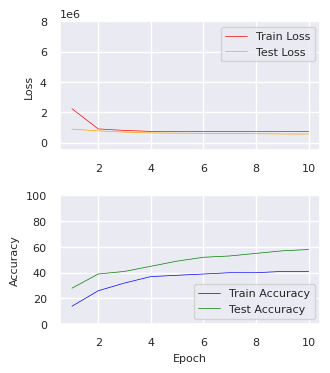

In [25]:
# Data/results directories
result_tag = 'original_runner'
data_dir = '../data'
results_dir = '../results/run_results/runner'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Data loader
db_file = os.path.join(data_dir, 'SARS_CoV_2_spike_noX_RBD.db')
train_dataset = SeqDataset(db_file, "train")
test_dataset = SeqDataset(db_file, "test")

# -= HYPERPARAMETERS =-
embedding_dim = 320
dropout = 0.1
max_len = 280
mask_prob = 0.15
n_transformer_layers = 12
attn_heads = 10
hidden = embedding_dim

batch_size = 64
n_test_baches = 200
num_epochs = 10

lr = 1e-05
weight_decay = 0.01
warmup_steps = 435 # (training set size / batch size) * 0.1
betas=(0.9, 0.999)

tokenizer = ProteinTokenizer(max_len, mask_prob)
embedder = NLPEmbedding(embedding_dim, max_len,dropout)
vocab_size = len(token_to_index)

SAVE_MODEL = True
LOAD_MODEL = False
CHECKPOINT = False
model_pth = os.path.join(results_dir, '../ddp_runner/ddp-2023-10-06_20-16/ddp-2023-10-06_20-16_best_model_weights.pth') # 320

USE_GPU = True
device = torch.device("cuda:0" if torch.cuda.is_available() and USE_GPU else "cpu")

torch.manual_seed(0)        # Dataloader uses its own random number generator.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
runner = Model_Runner(SAVE_MODEL, LOAD_MODEL, CHECKPOINT, model_result,
                        vocab_size=vocab_size, embedding_dim=embedding_dim, dropout=dropout, 
                        max_len=max_len, mask_prob=mask_prob, n_transformer_layers=n_transformer_layers,
                        n_attn_heads=attn_heads, batch_size=batch_size, lr=lr, betas=betas,
                        weight_decay=weight_decay, warmup_steps=warmup_steps, device=device)

if LOAD_MODEL and os.path.exists(model_pth):
    runner.model_pth = model_pth
    runner._load_model(runner.model_pth)
    runner.model.train()
    print(f"Loading from saved model at Epoch {runner.epochs_ran}")
elif LOAD_MODEL and not os.path.exists(model_pth):
    print(f"The .pth file {model_pth} does not exist; there is no model to load. Ending program.")
    exit()

runner.run(train_data = train_loader, test_data = test_loader,
            num_epochs = num_epochs, max_batch = n_test_baches)

The performance here isn't that great, but we shrunk down the data set size with `n_test_baches`. With more data, it performs better.

Let's try this again, this time doing a full run through 1 epoch and loading from a best saved model (320). Note that the hyperparameters should match the `model_pth` that you load in, especially `embedding_dim` and `attn_heads`. We should see the heatmap, but ignore the loss/accuracy plot.

Map saved status from 0 to cuda:0.
Loading from saved model at Epoch 1


EP_test: 1: 100%|| 1087/1087 [04:22<00:00,  4.13it/s]


	NEW BEST MODEL; model saved. ACC: 0.96, LOSS: 371037.36
Epoch 1 | train loss: 4327536.04, train accuracy: 0.89, test loss: 371037.36, test accuracy: 0.96, time: 00:51:41.99


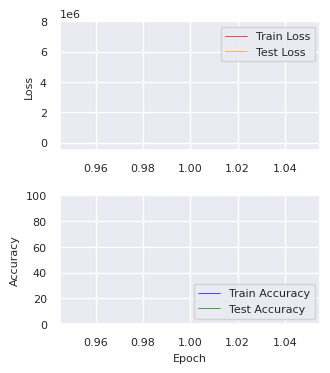

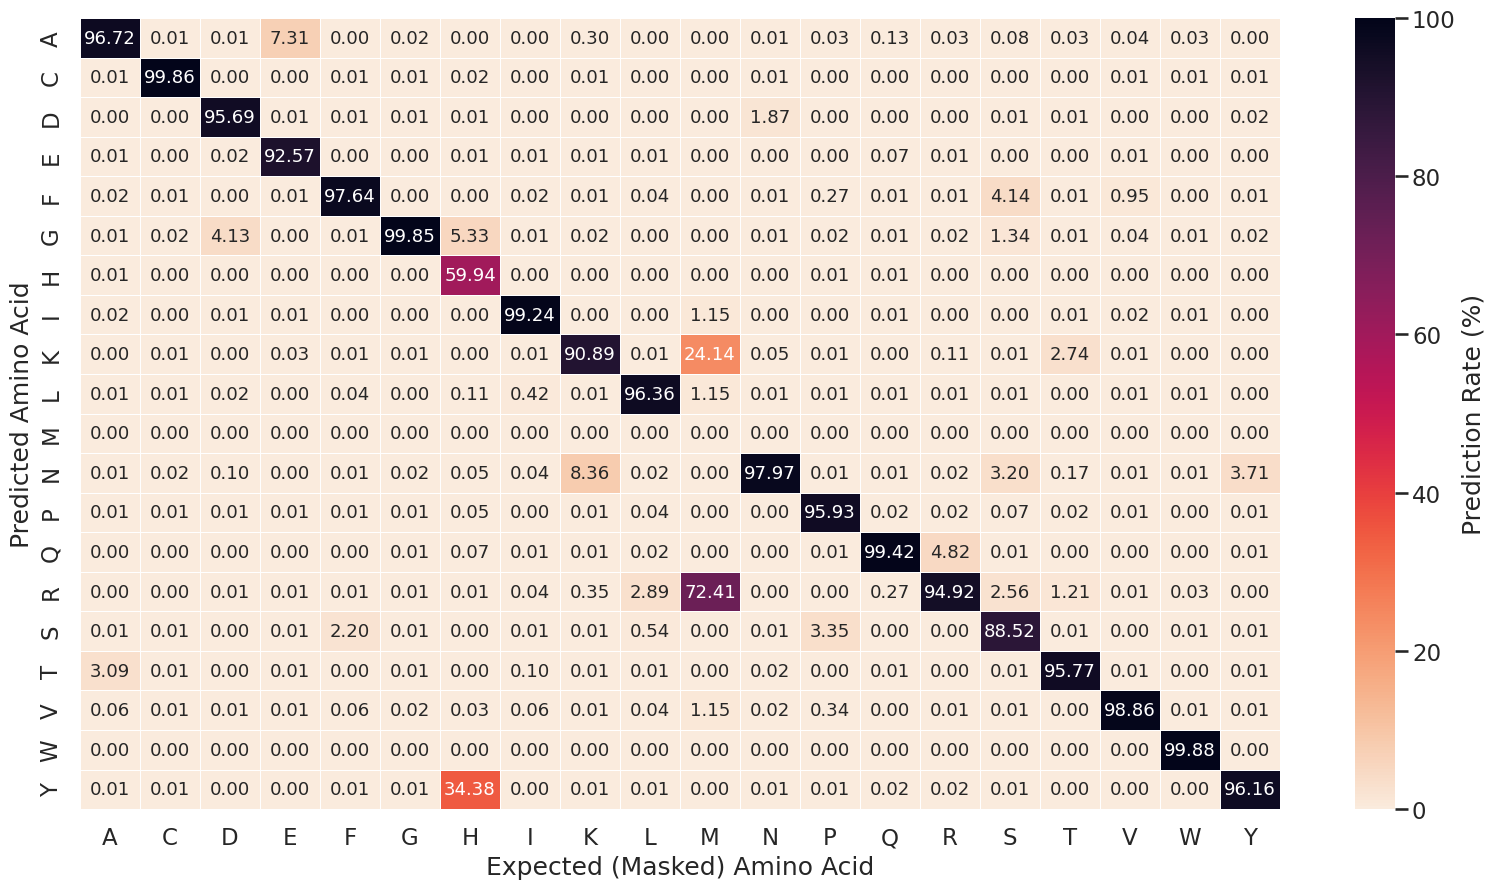

In [26]:
# Data/results directories
result_tag = 'original_runner'
data_dir = '../data'
results_dir = '../results/run_results/runner'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Data loader
db_file = os.path.join(data_dir, 'SARS_CoV_2_spike_noX_RBD.db')
train_dataset = SeqDataset(db_file, "train")
test_dataset = SeqDataset(db_file, "test")

# -= HYPERPARAMETERS =-
embedding_dim = 320
dropout = 0.1
max_len = 280
mask_prob = 0.15
n_transformer_layers = 12
attn_heads = 10
hidden = embedding_dim

batch_size = 64
n_test_baches = -1
num_epochs = 1

lr = 1e-05
weight_decay = 0.01
warmup_steps = 435 # (training set size / batch size) * 0.1
betas=(0.9, 0.999)

tokenizer = ProteinTokenizer(max_len, mask_prob)
embedder = NLPEmbedding(embedding_dim, max_len,dropout)
vocab_size = len(token_to_index)

SAVE_MODEL = True
LOAD_MODEL = True
CHECKPOINT = False
model_pth = os.path.join(results_dir, '../ddp_runner/ddp-2023-10-06_20-16/ddp-2023-10-06_20-16_best_model_weights.pth') # 320

USE_GPU = True
device = torch.device("cuda:0" if torch.cuda.is_available() and USE_GPU else "cpu")

torch.manual_seed(0)        # Dataloader uses its own random number generator.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
runner = Model_Runner(SAVE_MODEL, LOAD_MODEL, CHECKPOINT, model_result,
                        vocab_size=vocab_size, embedding_dim=embedding_dim, dropout=dropout, 
                        max_len=max_len, mask_prob=mask_prob, n_transformer_layers=n_transformer_layers,
                        n_attn_heads=attn_heads, batch_size=batch_size, lr=lr, betas=betas,
                        weight_decay=weight_decay, warmup_steps=warmup_steps, device=device)

if LOAD_MODEL and os.path.exists(model_pth):
    runner.model_pth = model_pth
    runner._load_model(runner.model_pth)
    runner.model.train()
    print(f"Loading from saved model at Epoch {runner.epochs_ran}")
elif LOAD_MODEL and not os.path.exists(model_pth):
    print(f"The .pth file {model_pth} does not exist; there is no model to load. Ending program.")
    exit()

runner.run(train_data = train_loader, test_data = test_loader,
            num_epochs = num_epochs, max_batch = n_test_baches)

### DistributedDataParallel BERT
Unfortunately, the DDP BERT model doesn't really work here in a jupyter notebook. But, it functions mostly the same. To run, see below.

Usage:
- torchrun
    - --standalone: utilize single node
    - --nproc_per_node: number of processes/gpus
- Example command to run (single node, 2 gpu)
    - `/usr/bin/time -v torchrun --standalone --nproc_per_node=2 gpu_ddp_runner.py`

And that is it! Now you can find the resulting saved model and other results in the `/results/run_results/` folder. You are ready to take the best `model_pth` and go create embeddings of data and/or go perform model transfer with the various models that we have available!

Additionally, much of this is the same process we used to create the results for the AlphaSeq Antibody results.